RAG MVP for Operator Training (text + images)

In [1]:
import os, io
from PIL import Image
import fitz  # PyMuPDF
import numpy as np
import faiss
from IPython.display import display

from sentence_transformers import SentenceTransformer
from langchain_openai import ChatOpenAI
from langchain.schema import Document


In [2]:
# --- 1) Settings ---
PDF_PATH = "data/ManualOp-Modo Manual SIF400_merged_SIF402.pdf"          # Place PDF here
MACHINE_NAME = "SIF402"               # Set the machine name
TOP_K = 3                             # Number of retrieved results

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
if not OPENAI_API_KEY:
    raise ValueError("OPENAI_API_KEY not found in env")

# --- 2) Models ---
text_model = SentenceTransformer("all-MiniLM-L6-v2")
clip_model = SentenceTransformer("clip-ViT-B-32")
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)


Could not cache non-existence of file. Will ignore error and continue. Error: [Errno 13] Permission denied: '/home/jovyan/.cache/huggingface/hub/models--sentence-transformers--all-MiniLM-L6-v2/.no_exist/c9745ed1d9f207416be6d2e6f8de32d1f16199bf/adapter_config.json'
Ignored error while writing commit hash to /home/jovyan/.cache/huggingface/hub/models--sentence-transformers--clip-ViT-B-32/refs/main: [Errno 13] Permission denied: '/home/jovyan/.cache/huggingface/hub/models--sentence-transformers--clip-ViT-B-32/refs/main'.
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [3]:
# --- 3) Load PDF ---
doc = fitz.open(PDF_PATH)
text_docs, text_embeddings = [], []
image_docs, image_embeddings = [], []

for page_num in range(len(doc)):
    page = doc[page_num]

    # Text
    text = page.get_text()
    if text.strip():
        emb = text_model.encode(text).astype("float32")
        text_embeddings.append(emb)
        text_docs.append(
            Document(
                page_content=text,
                metadata={"page": page_num+1, "machine": MACHINE_NAME}
            )
        )

    # Images
    img_list = page.get_images(full=True)
    for img_index, img in enumerate(img_list, start=1):
        xref = img[0]
        base_img = doc.extract_image(xref)
        img_bytes = base_img["image"]
        img_ext = base_img["ext"]
        img_obj = Image.open(io.BytesIO(img_bytes)).convert("RGB")

        out_path = f"data/page{page_num+1}_img{img_index}.{img_ext}"
        img_obj.save(out_path)

        emb = clip_model.encode(img_obj).astype("float32")
        image_docs.append(
            Document(
                page_content=f"{MACHINE_NAME}_unknown image on page {page_num+1}, index {img_index}",
                metadata={
                    "page": page_num+1,
                    "img_path": out_path,
                    "machine": MACHINE_NAME,
                    "object_tag": f"{MACHINE_NAME}_unknown"
                }
            )
        )
        image_embeddings.append(emb)



In [4]:
# --- 4) Build FAISS indexes ---
text_embeddings = np.vstack(text_embeddings)
image_embeddings = np.vstack(image_embeddings)

text_index = faiss.IndexFlatL2(text_embeddings.shape[1])
text_index.add(text_embeddings)

image_index = faiss.IndexFlatL2(image_embeddings.shape[1])
image_index.add(image_embeddings)

print(f"Indexed {len(text_docs)} text chunks and {len(image_docs)} images.")



Indexed 39 text chunks and 248 images.


In [5]:
# --- 5) Retriever ---
def retrieve(query, k=TOP_K):
    q_text_emb = text_model.encode(query).astype("float32")
    q_img_emb = clip_model.encode(query).astype("float32")

    # Text retrieval
    D, I = text_index.search(np.array([q_text_emb]), k)
    text_results = [text_docs[i] for i in I[0]]

    # Image retrieval
    D, I = image_index.search(np.array([q_img_emb]), k)
    image_results = [image_docs[i] for i in I[0]]

    return text_results, image_results

# --- 6) RAG answer ---
def ask(query, k=TOP_K):
    text_results, image_results = retrieve(query, k)

    # Prepare context
    context_parts = []
    for t in text_results:
        context_parts.append(f"[Text | Page {t.metadata['page']} | {t.metadata['machine']}]\n{t.page_content}")
    for im in image_results:
        context_parts.append(f"[Image | Page {im.metadata['page']} | Tag: {im.metadata['object_tag']}] {im.metadata['img_path']}")

    context = "\n\n".join(context_parts)
    prompt = f"""
    You are a safety-minded operator assistant.
    Query: {query}

    Context:
    {context}

    Answer step-by-step and cite sources (pages and object tags)."""

    # Generate answer
    answer = llm.invoke(prompt).content

    print("\n=== Answer ===\n")
    print(answer)

    print("\n=== Supporting Images ===\n")
    for im in image_results:
        print(f"- Page {im.metadata['page']} | Tag: {im.metadata['object_tag']}")
        display(Image.open(im.metadata["img_path"]))





=== Answer ===

To reset the emergency stop button on the SIF402 control panel, follow these steps:

1. **Identify the Emergency Stop Situation**: Ensure that the emergency stop button has been pressed and the system is in "Emergency status." The HMI panel will display this message.

2. **Check the HMI Panel**: Look for the status message in the lower alert table on the HMI panel. This will provide guidance on the next steps to take.

3. **Locate the RESET Button**: Find the RESET button on the control panel. 

4. **Check the RESET Button Status**: Ensure that the RESET button is active. If it is active, you will see a flashing blue light in the title of the button.

5. **Press the RESET Button**: If the RESET button is active (flashing blue), press it to exit the emergency state and recover the station. 

6. **Verify Recovery**: After pressing the RESET button, check the HMI panel to confirm that the emergency status has cleared and the system is operational again.

7. **Resume Norma

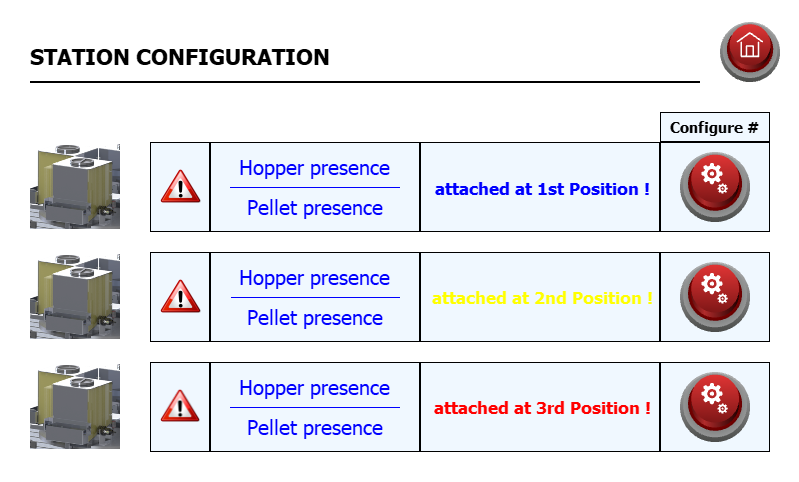

- Page 19 | Tag: SIF402_unknown


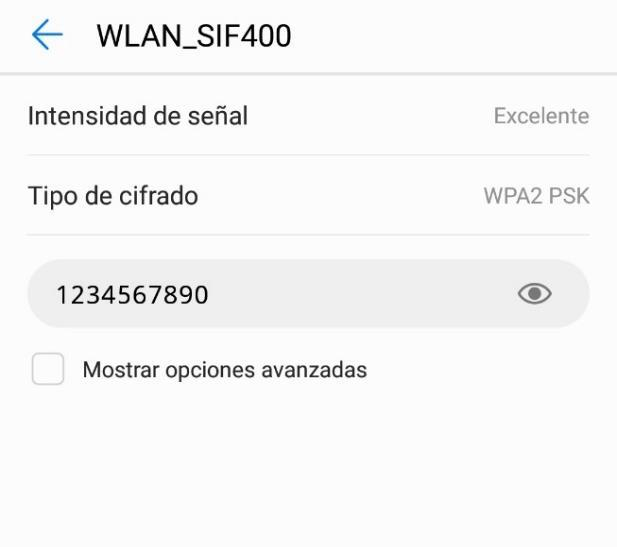

- Page 26 | Tag: SIF402_unknown


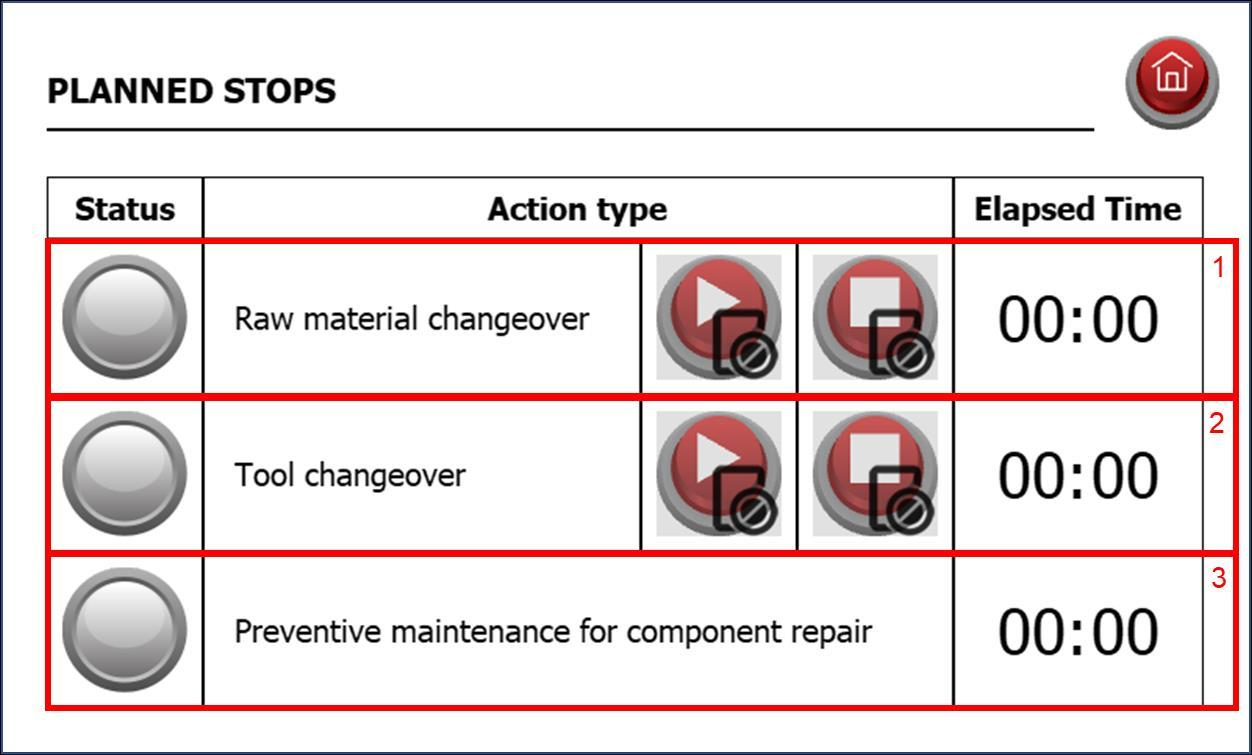

In [6]:
# --- 7) Example usage ---
if __name__ == "__main__":
    ask(f"How to reset emergency stop button on {MACHINE_NAME} control panel?")